In [1]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tomsu\Desktop\strategicDeployment\code\utils.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(state, dtype=torch.float32),
c:\Users\tomsu\Desktop\strategicDeployment\code\utils.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(next_state, dtype=torch.float32),


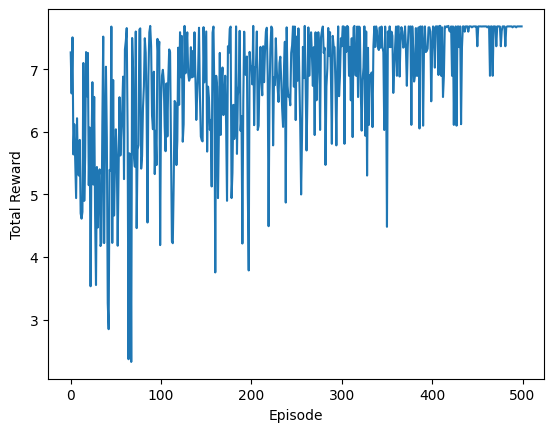

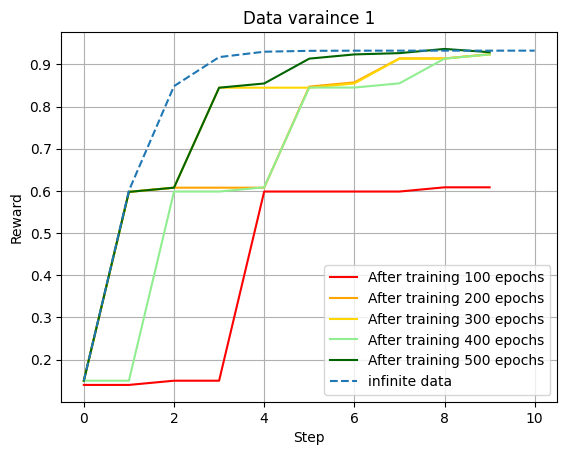

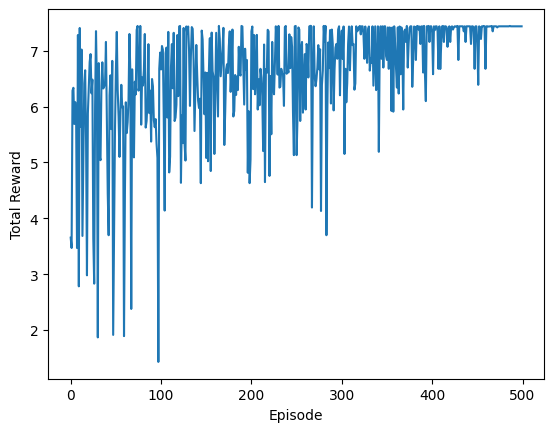

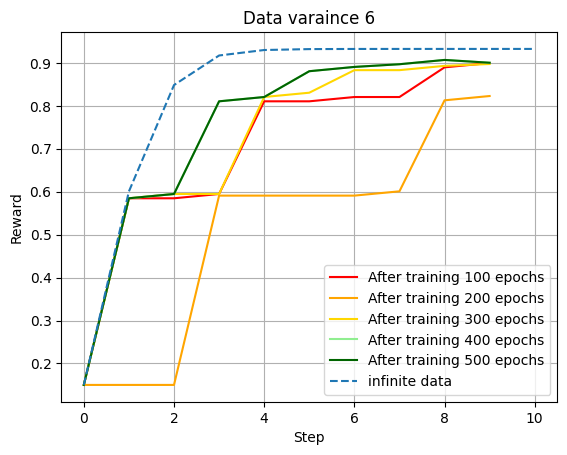

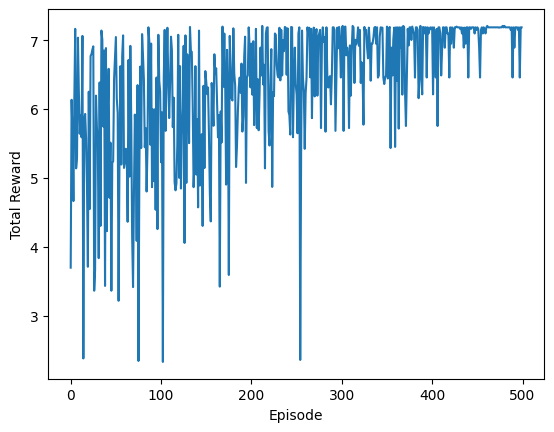

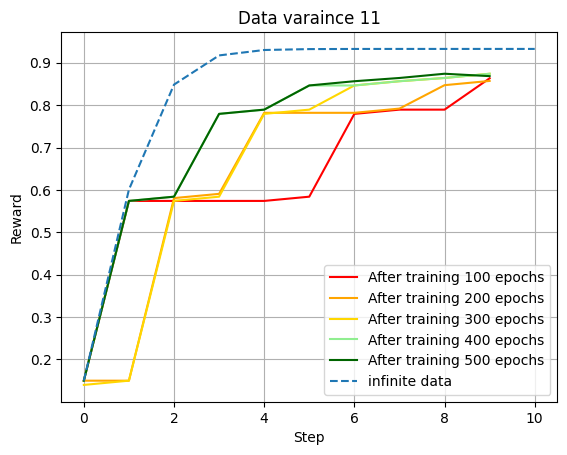

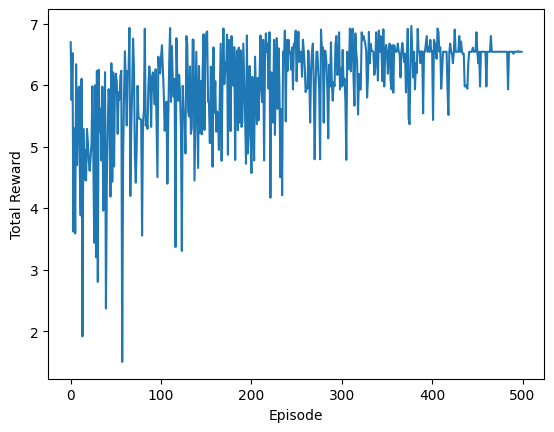

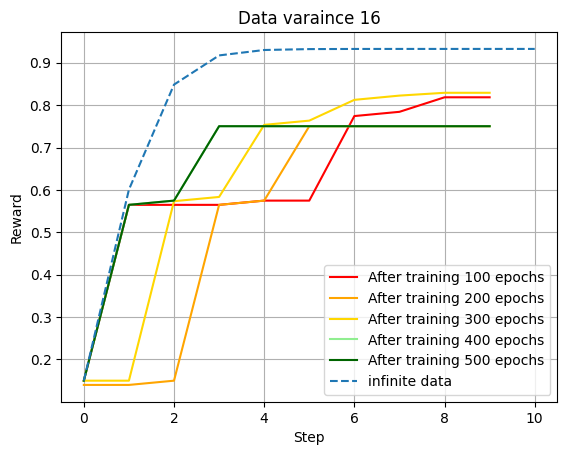

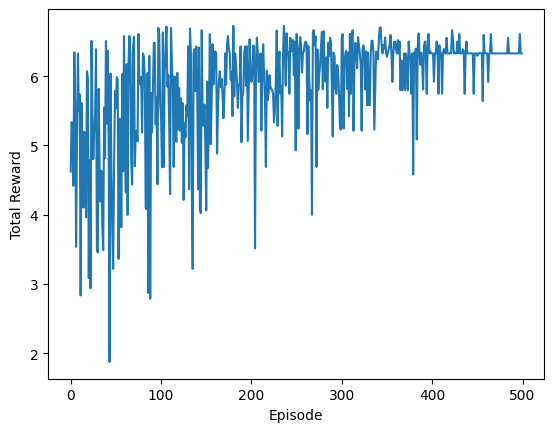

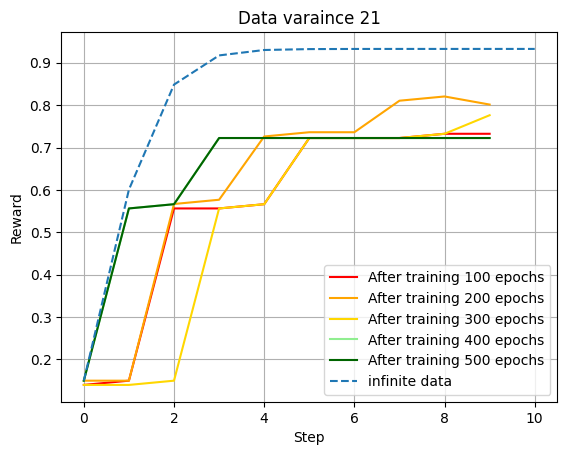

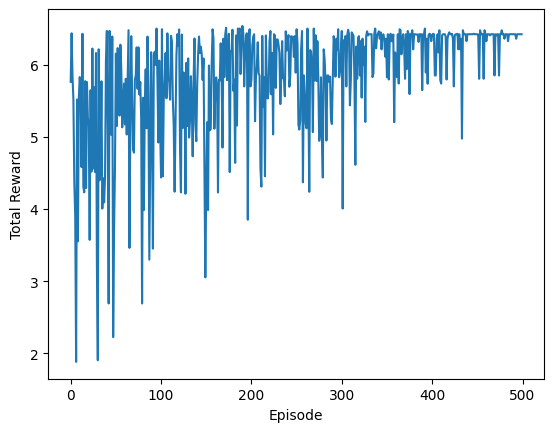

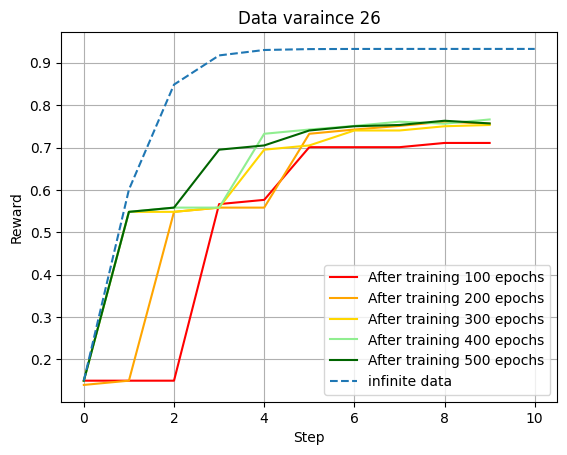

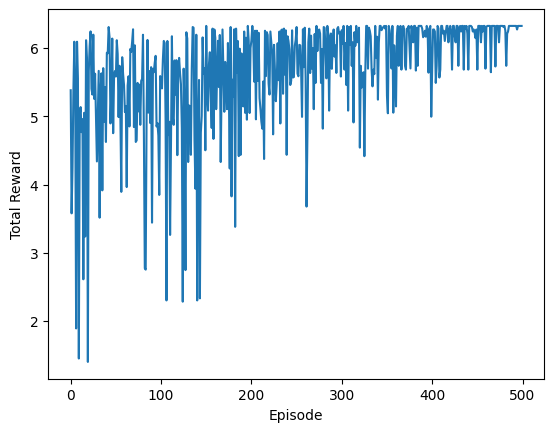

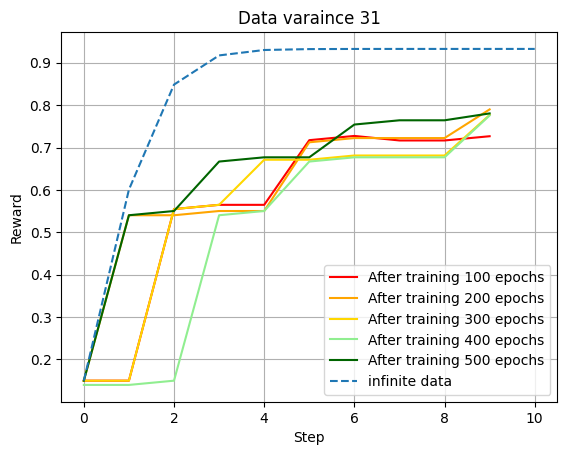

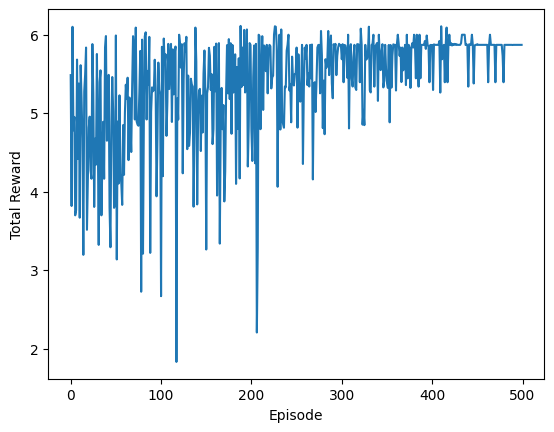

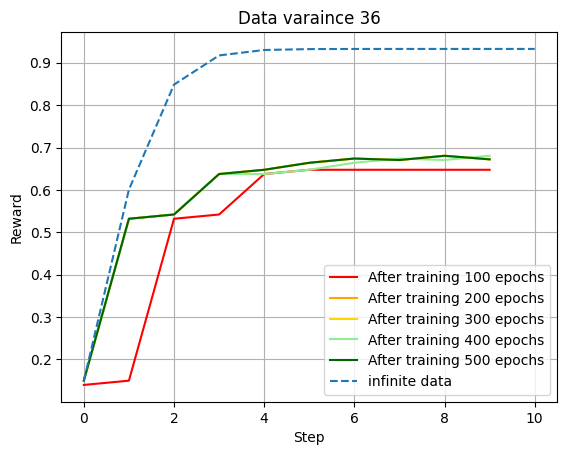

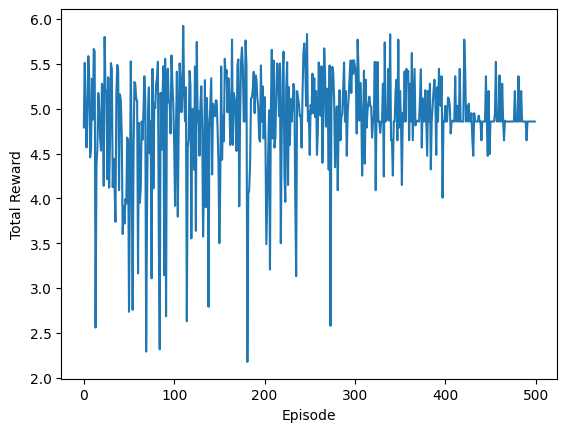

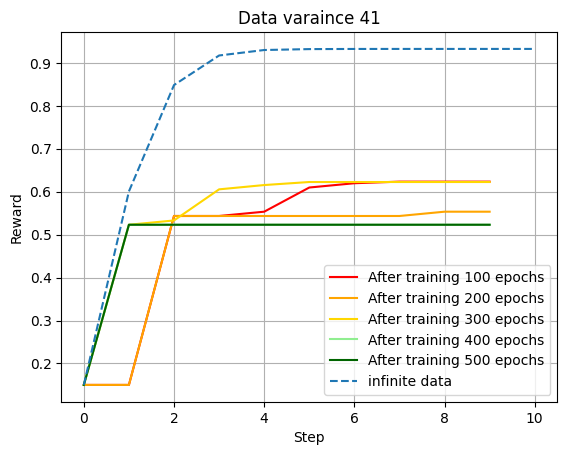

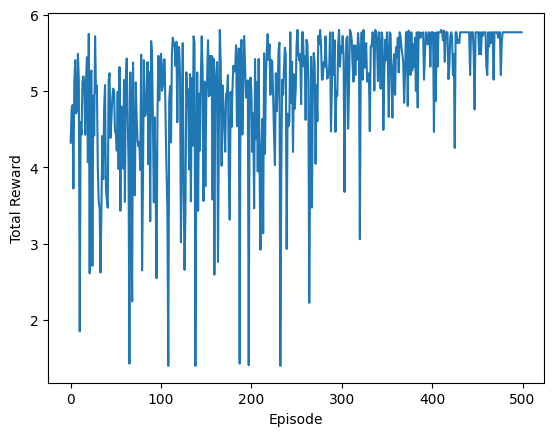

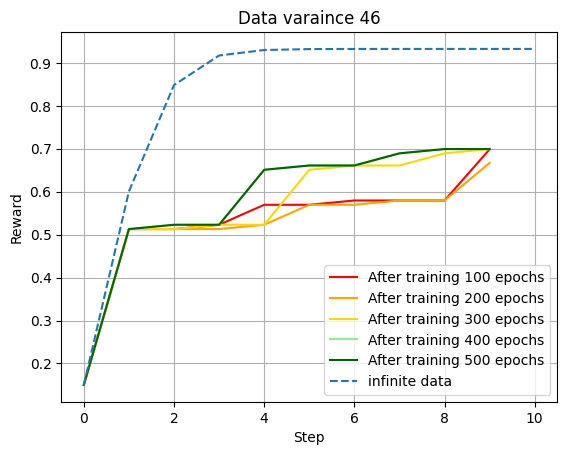

In [2]:
# Initialize environment
num_episodes = 500
deployment_cost=0.01 
ccf_beta = 3.0
data_collection_size = 3000
data_variances = range(1,50,5) #equivalent to lowering deployment cost
episode_length = 10

plots_all = {}
for data_variance in data_variances:
    params = {
    "start_utility": 0.15,
    "time_preference": 0.95,
    "data_collection_size": data_collection_size,
    "max_utility": 1.0,
    "ccf_beta": ccf_beta,
    "filename": f"best_strategy_{data_collection_size}.png",
    "data_variance": data_variance
    }
    q_net = QNetwork(input_size=2, output_size=2)  # 1 state feature, 2 actions
    target_net = QNetwork(input_size=2, output_size=2)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=1e-3)

    replay_buffer = ReplayBuffer(capacity=3000)
    rewards, plot_data = train_q_learning(params, q_net, target_net, optimizer, replay_buffer, num_episodes=num_episodes, deployment_cost=deployment_cost, epsilon_start=1.0, episode_length=episode_length)
    plots_all[str(data_variance)] = plot_data
    
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()
    counter = 0
    color = 0
    colors = ["red","orange","gold","lightgreen","darkgreen"]
    for d in plot_data:
        counter = counter + 1
        if counter % 100 == 0:
            plt.plot(d, label=f"After training {counter} epochs", color=colors[color])
            color = color +1
        # else:
        #     plt.plot(d, color="gray", alpha=0.1)
    plt.xlabel('Step')
    plt.plot(get_upperbound(params["start_utility"],deployment_cost=deployment_cost, episode_length=episode_length), label="infinite data", linestyle="--")
    plt.ylabel('Reward')
    plt.grid()
    plt.title(f'Data varaince {data_variance}')
    plt.legend()
    plt.show()


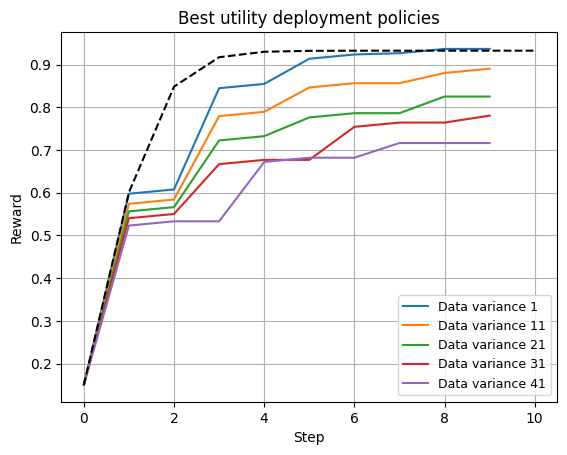

In [3]:
counter = 0
color = 0
# colors = ["red","orange","gold","lightgreen","darkgreen"]
for d in plots_all.keys():
        counter=counter+1
        if counter % 2 == 0:
                continue
        utilityseries = plots_all[d]
        max_util = 0
        to_plot = 0
        for j in range(0,len(utilityseries)):
                current_val = get_discounted_utility(1-params["time_preference"], utilityseries[j])
                if current_val>max_util:
                        max_util = current_val
                        to_plot = utilityseries[j]
        plt.plot(to_plot, label=f"Data variance {d}")
        # color = color +1
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend(fontsize=9)
plt.title("Best utility deployment policies")
plt.plot(get_upperbound(params["start_utility"],deployment_cost=deployment_cost), label="infinite data", linestyle="--", color="black")
plt.grid()
plt.show()


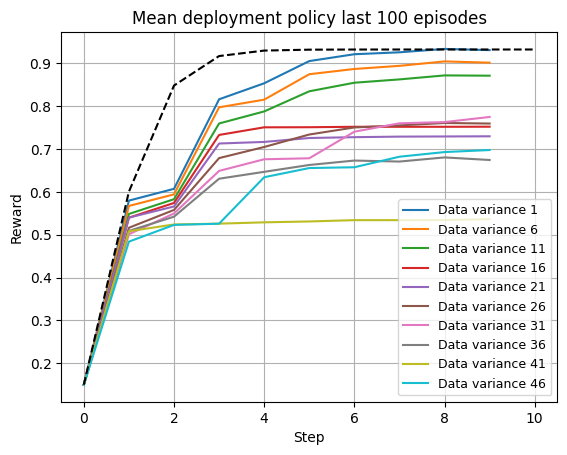

In [4]:
counter = 0
color = 0
# colors = ["red","orange","gold","lightgreen","darkgreen"]
for d in plots_all.keys():
        utilityseries = plots_all[d]
        utilityseries = np.mean(utilityseries[450:], axis=0)
        max_util = 0
        to_plot = 0
        plt.plot(utilityseries, label=f"Data variance {d}")
        # color = color +1
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend(fontsize=9)
plt.title("Mean deployment policy last 100 episodes")
plt.plot(get_upperbound(params["start_utility"],deployment_cost=deployment_cost), label="infinite data", linestyle="--", color="black")
plt.grid()
plt.show()


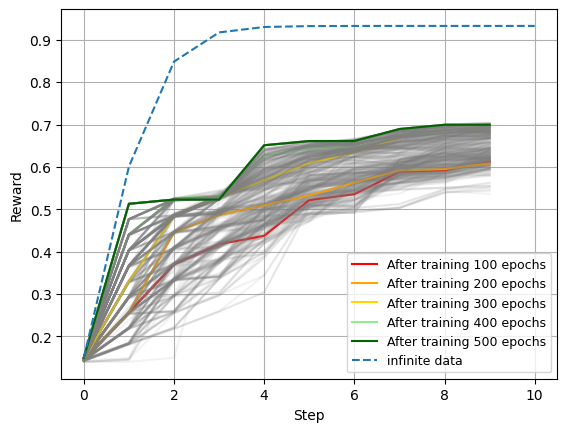

In [5]:
import pandas as pd
df = pd.DataFrame(plot_data)

# Apply rolling window with size 10 and compute the mean
rolling_avg = df.rolling(window=10, min_periods=1).mean()

# Convert back to list of lists if needed
result = rolling_avg.values.tolist()

counter = 0
color = 0
colors = ["red","orange","gold","lightgreen","darkgreen"]
for d in result:
    counter = counter + 1
    if counter % 100 == 0:
        plt.plot(d, label=f"After training {counter} epochs", color=colors[color])
        color = color +1
    else:
        plt.plot(d, color="gray", alpha=0.1)
plt.plot(get_upperbound(params["start_utility"],deployment_cost=deployment_cost), label="infinite data", linestyle="--")
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend(fontsize=9)
plt.grid()
plt.show()

In [6]:
def calculate_chunk_averages(data, chunk_size=100):
    # Convert to NumPy array for easier operations
    data_array = np.array(data)
    n_chunks = len(data_array) // chunk_size
    
    # Calculate average for each chunk
    chunk_averages = [
        data_array[i * chunk_size : (i + 1) * chunk_size].mean(axis=0)
        for i in range(n_chunks)
    ]
    return chunk_averages

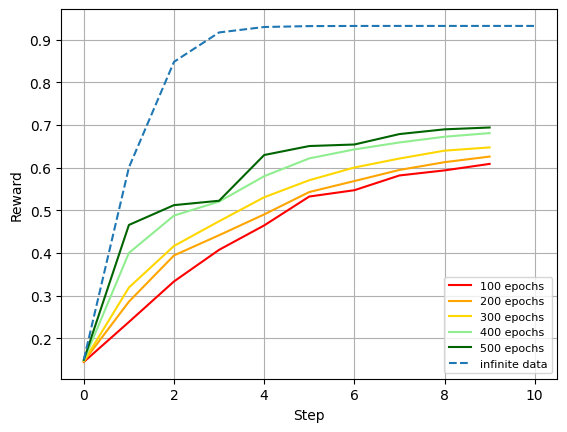

In [7]:
counter = 0
color = 0
colors = ["red","orange","gold","lightgreen","darkgreen"]
result = calculate_chunk_averages(plot_data)
for d in result:
    counter = counter + 1
    plt.plot(d, label=f"{counter*100} epochs", color=colors[color])
    color = color +1
    #else:
     #   plt.plot(d, color="gray", alpha=0.1)
plt.plot(get_upperbound(params["start_utility"],deployment_cost=deployment_cost), label="infinite data", linestyle="--")
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend(fontsize=8)
plt.grid()
plt.show()
